In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import h5py

from sigcorr.config import CFG

from sigcorr.tools.utils import get_last_from_iter
from sigcorr.tools.visual import set_plt_reasonable_defaults

from sigcorr.tools.euler_number import euler_number_along_zero_ax

from sigcorr.mapreduce.gp import gp_batch_mapreduce
from sigcorr.mapreduce.file import h5_batch_mapreduce

from sigcorr.mapreduce.map_reducers import SigsCalc
from sigcorr.mapreduce.map_reducers import BatchStats2Reduce

from sigcorr.tools.visual import plot_norm_pulls

from sigcorr.models.gross_vitells import GrossVitells
from sigcorr.models.gross_vitells_asimov import GrossVitellsAsimov
from sigcorr.models.hyy import Hyy
from sigcorr.models.hyy_asimov import HyyAsimov
from sigcorr.models.hyy_2d import Hyy2D
from sigcorr.models.hyy_2d_asimov import Hyy2DAsimov
from sigcorr.models.utils import set_params_from_file


CFG.FITTER.bfit_pool_size = 60  # gp draws use this pool size
set_plt_reasonable_defaults(plt)

In [2]:
#input_file = "../../output/hyy2d-2560.h5"
input_file = "../../output/hyy-1m.h5"
#input_file = "../../output/gross_vitells200k-1m.h5"
asimov_input_file = input_file.split("-")[0] + "-asimov.h5"

In [3]:
true_res_part = {}
with h5py.File(input_file, "r") as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "sb_successes", "b_successes"]:
        true_res_part[field] = f[field][:100000, ...]
    true_res_part["scan_xs"] = f["scan_xs"][...]

In [4]:
#model = GrossVitellsAsimov(None)
model = HyyAsimov(None)
#model = Hyy2DAsimov(None)
set_params_from_file(model, input_file)
model.init()

In [5]:
asimov_res = {}
with h5py.File(asimov_input_file, "r") as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "bg_samples"]:
        asimov_res[field] = f[field][...]

In [6]:
c0 = 0.7

In [7]:
true_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
true_cov, true_cov_err = true_covcalc.get_cov(), true_covcalc.get_cov_stat_err()
true_corr, true_corr_err = true_covcalc.get_corr(), true_covcalc.get_corr_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:01<00:00, 598750.82it/s]


In [8]:
asimov_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(asimov_input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
asimov_cov, asimov_cov_err = asimov_covcalc.get_cov(), asimov_covcalc.get_cov_stat_err()
asimov_corr, asimov_corr_err = asimov_covcalc.get_corr(override_x=np.array(0)), asimov_covcalc.get_corr_stat_err(override_x=np.array(0))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 3915153.55it/s]


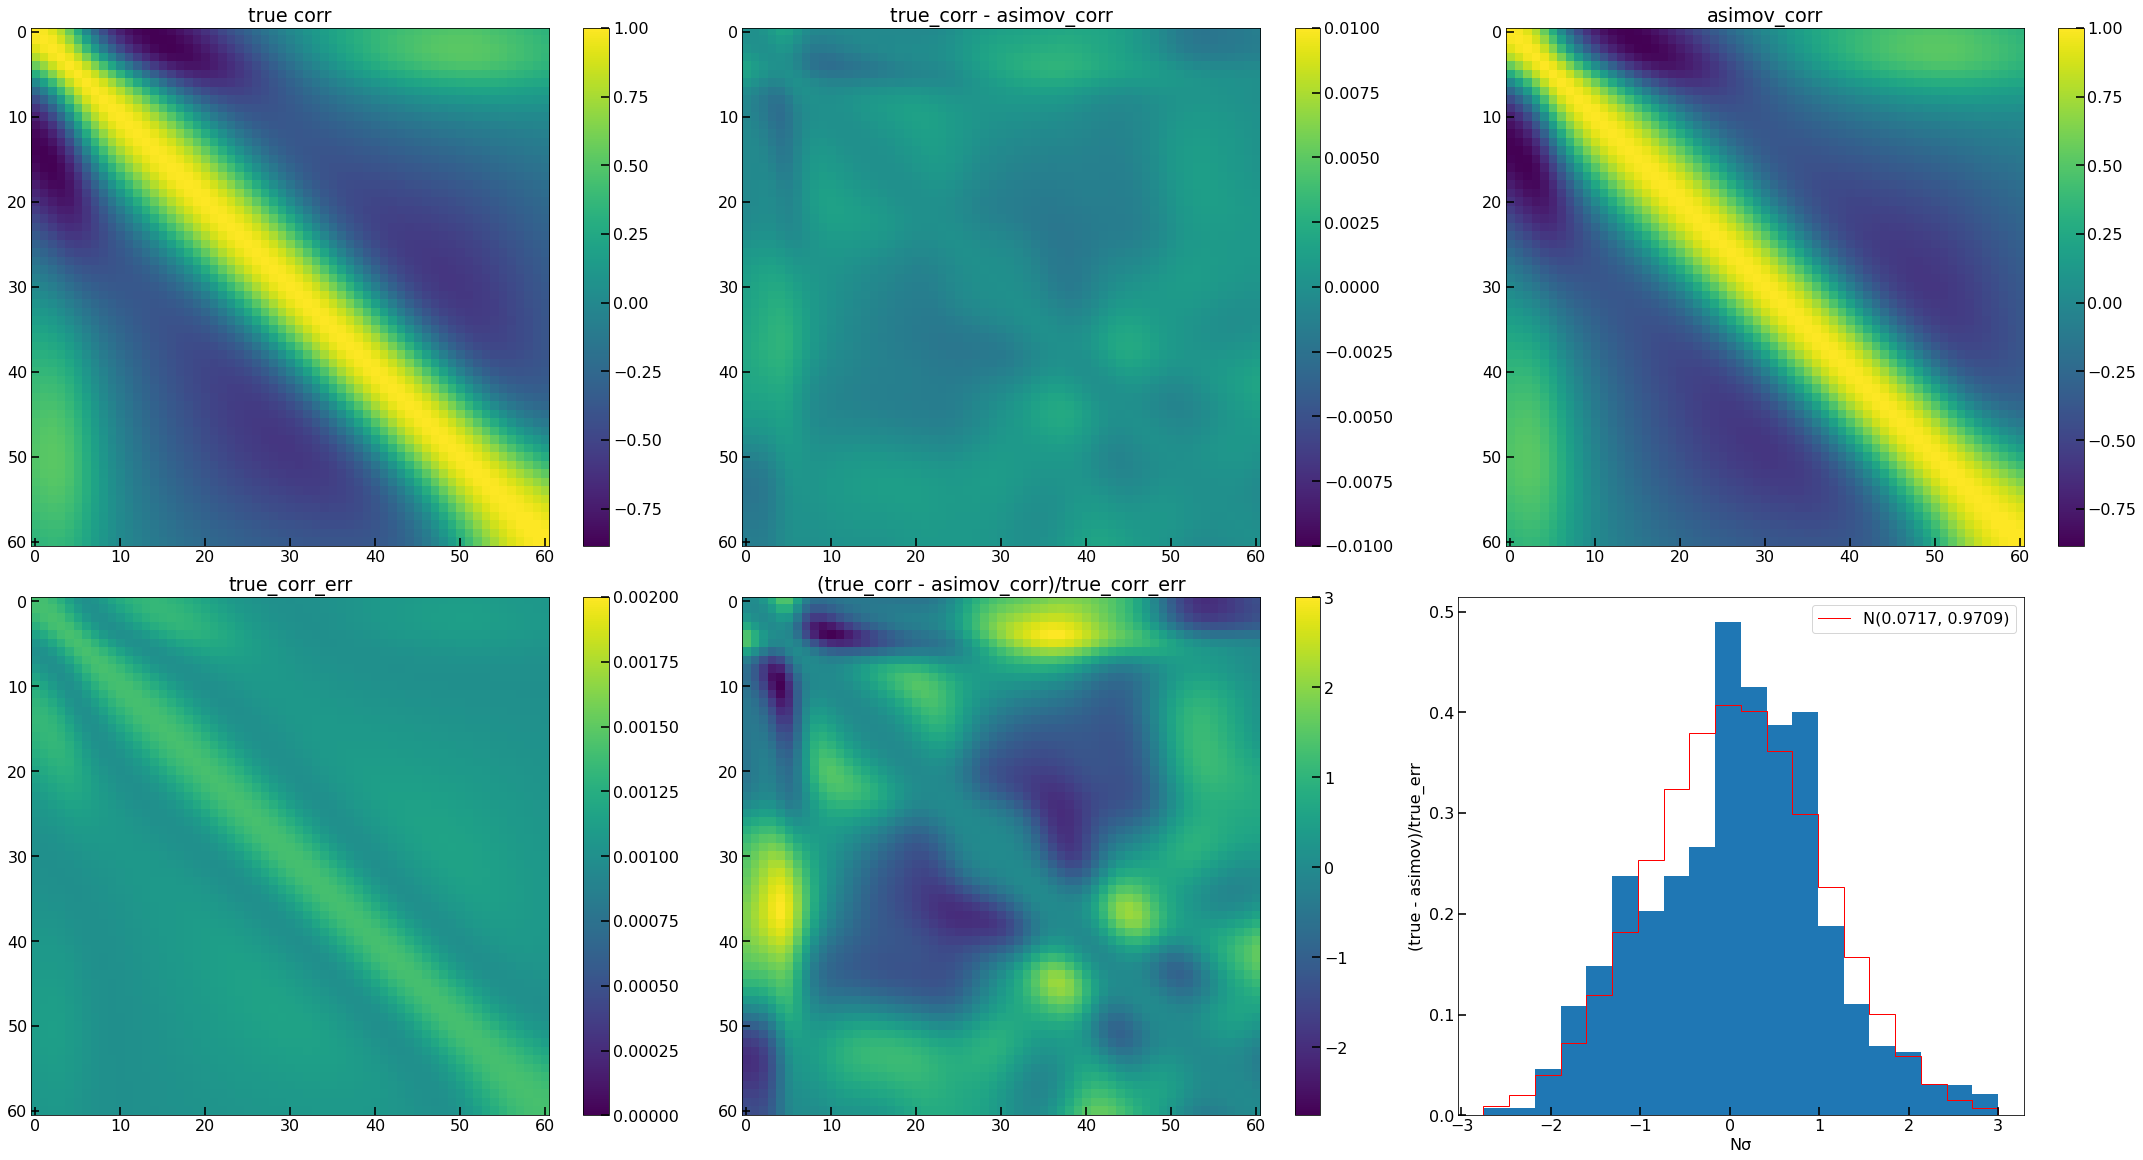

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 16))
m = ax[0, 0].imshow(true_corr, origin="upper")
plt.colorbar(mappable=m, ax=ax[0, 0])
ax[0, 0].set_title("true corr")

m = ax[0, 1].imshow(true_corr - asimov_corr, origin="upper", vmin=-0.01, vmax=0.01)
plt.colorbar(mappable=m, ax=ax[0, 1])
ax[0, 1].set_title("true_corr - asimov_corr")

m = ax[0, 2].imshow(asimov_corr, origin="upper")
plt.colorbar(mappable=m, ax=ax[0, 2])
ax[0, 2].set_title("asimov_corr");

m = ax[1, 0].imshow(true_corr_err, origin="upper", vmin=0, vmax=0.002)
plt.colorbar(mappable=m, ax=ax[1, 0])
ax[1, 0].set_title("true_corr_err");

m = ax[1, 1].imshow((true_corr - asimov_corr)/true_corr_err, origin="upper")
plt.colorbar(mappable=m, ax=ax[1, 1])
ax[1, 1].set_title("(true_corr - asimov_corr)/true_corr_err")

plot_norm_pulls(ax[1, 2], (true_corr - asimov_corr)/true_corr_err, subtract_diag=True)
ax[1, 2].set_ylabel("(true - asimov)/true_err")
ax[1, 2].set_xlabel("Nσ");
ax[1, 2].legend()

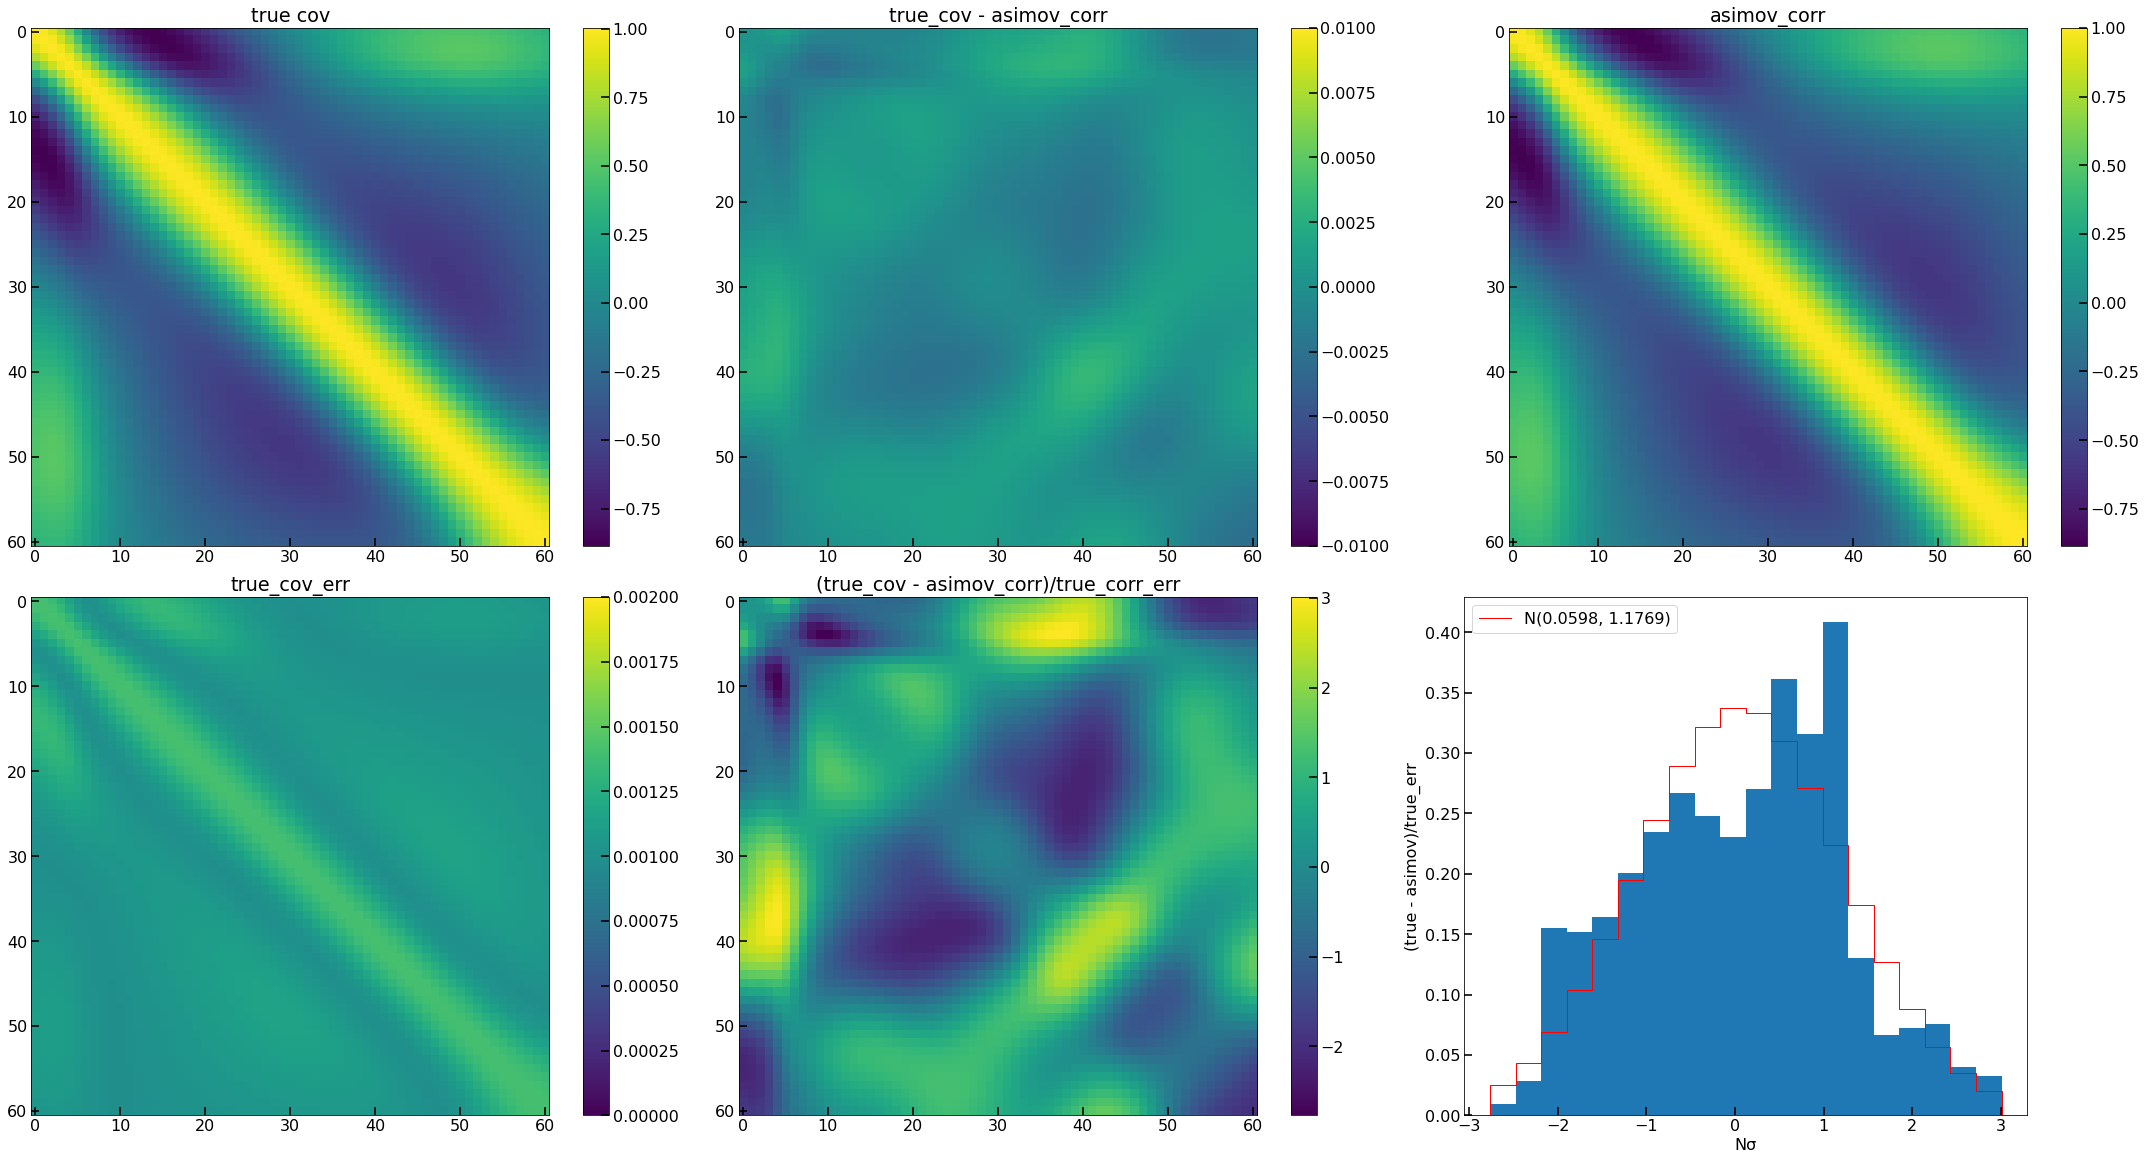

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 16))
m = ax[0, 0].imshow(true_cov, origin="upper")
plt.colorbar(mappable=m, ax=ax[0, 0])
ax[0, 0].set_title("true cov")

m = ax[0, 1].imshow(true_cov - asimov_corr, origin="upper", vmin=-0.01, vmax=0.01)
plt.colorbar(mappable=m, ax=ax[0, 1])
ax[0, 1].set_title("true_cov - asimov_corr")

m = ax[0, 2].imshow(asimov_corr, origin="upper")
plt.colorbar(mappable=m, ax=ax[0, 2])
ax[0, 2].set_title("asimov_corr");

m = ax[1, 0].imshow(true_cov_err, origin="upper", vmin=0, vmax=0.002)
plt.colorbar(mappable=m, ax=ax[1, 0])
ax[1, 0].set_title("true_cov_err");

m = ax[1, 1].imshow((true_cov - asimov_corr)/true_corr_err, origin="upper")
plt.colorbar(mappable=m, ax=ax[1, 1])
ax[1, 1].set_title("(true_cov - asimov_corr)/true_corr_err")

plot_norm_pulls(ax[1, 2], (true_cov - asimov_corr)/true_corr_err, subtract_diag=True)
ax[1, 2].set_ylabel("(true - asimov)/true_err")
ax[1, 2].set_xlabel("Nσ");
ax[1, 2].legend()